In [40]:
#Imports
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.model_selection import train_test_split

In [ ]:
#MPS config (apple m1) & seed config
torch.mps.empty_cache()
device = torch.device("mps" if torch.mps.is_available() else "cpu")
torch.manual_seed(20) #VERY VERY IMPORTANT SO CAN REPRODUCE THE SAME RESULT ON DIF PARAMS!!

In [177]:
#hyper parameters
n_epochs = 3
batchsize = 64
learning_rate = 0.001

In [178]:
#Classes & transforms
#ToTensor
data_transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,),(0.5,))])
# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, image_ids, labels, image_dir='input/images', transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        #get image pathhh
        img_name = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_name}.png")

        #load image
        image = Image.open(img_path).convert('1')

        #apply transforms
        if self.transform:
            image = self.transform(image)
        
        #get label
        label = self.labels[idx]

        return image, label
    
    #ConvNet Class
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1 = nn.Linear(16*36*36, 256)
        self.fc2 = nn.Linear(256, 1)
        #self.fc3 = nn.Linear(603, 1)
        #self.fc4 = nn.Linear(750, 1)
        self.dropout2d = nn.Dropout2d(p=0.2)
        self.dropout = nn.Dropout(p=0.4)
        self.tanh =nn.Tanh()
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout2d(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2d(x)
        #x = self.pool(F.relu(self.conv3(x)))
        #flatten
        x = x.view(-1, 16*36*36)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        #x = self.fc3(x)
        x = self.tanh(x)
        x = x.squeeze(1) #To make the tensor shape the same with loss function
        return x

In [179]:
#import data, train_val_test_split
#datafile
data_file = pd.read_csv('input/responses.csv')

image_id = data_file['id'].values
labels = data_file['corr'].values
print(len(image_id))

X_train, X_valtest, y_train, y_valtest = train_test_split(image_id,
                                                          labels,
                                                          test_size=0.2,
                                                          random_state=42,
                                                          shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(X_valtest, 
                                                y_valtest,
                                                test_size=0.5,
                                                random_state=42,
                                                shuffle=True)

print(f'len of train data: {len(X_train)}')
print(f'len of train label: {len(y_train)}')
print(f'len of val data: {len(X_val)}')
print(f'len of test data: {len(X_test)}')

150000
len of train data: 120000
len of train label: 120000
len of val data: 15000
len of test data: 15000


In [181]:
#create datasets
train_dataset = ImageDataset(X_train, y_train, image_dir = 'input/images', transform=data_transforms)
val_dataset = ImageDataset(X_val, y_val, image_dir='input/images', transform=data_transforms)
test_dataset = ImageDataset(X_test, y_test, image_dir='input/images', transform=data_transforms)

#create dataloaders
train_load = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
val_load = torch.utils.data.DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
test_load = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

In [182]:
model = ConvNet().to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_total_steps = len(train_load)

In [183]:
#Training 
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_load):
        images = images.to(device)
        labels = labels.to(torch.float32).to(device)

        #forward 
        model.train()
        outputs = model(images)
        loss = criterion(outputs, labels)

        #loss & optim
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1}/{n_epochs}, steps: {i+1}/{n_total_steps}, loss: {loss.item()}')
        if (i+1) % 200 == 0:
            model.eval()
            all_prediction_labels = []
            all_val_labels = []
            val_loss=0
            with torch.no_grad():
                for val_images, val_labels in val_load:
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(torch.float32).to(device)
                    
                    all_val_labels.extend(val_labels.cpu().numpy())

                    val_outputs = model(val_images)
                    val_loss += criterion(val_outputs, val_labels).item()
                    all_prediction_labels.extend(val_outputs.cpu().numpy())

            corr = float(np.corrcoef(all_val_labels,all_prediction_labels)[0,1])
            val_loss = val_loss/len(val_load)
            print(f'val loss:{val_loss}')
            print(f'corr at epoch:{epoch+1}={corr}')

            model.train()
print('finished training')
print('starts testing')

epoch: 1/3, steps: 100/1875, loss: 0.02586258575320244
epoch: 1/3, steps: 200/1875, loss: 0.009682785719633102
val loss:0.01873897133355445
corr at epoch:1=0.9789678524942006
epoch: 1/3, steps: 300/1875, loss: 0.007223738357424736
epoch: 1/3, steps: 400/1875, loss: 0.0065261730924248695
val loss:0.014254420214986548
corr at epoch:1=0.9855916217556722
epoch: 1/3, steps: 500/1875, loss: 0.006897747050970793
epoch: 1/3, steps: 600/1875, loss: 0.007971454411745071
val loss:0.012065085380318316
corr at epoch:1=0.9906185701623387
epoch: 1/3, steps: 700/1875, loss: 0.00617464492097497
epoch: 1/3, steps: 800/1875, loss: 0.007612844929099083
val loss:0.00945452337371225
corr at epoch:1=0.9925774652047902
epoch: 1/3, steps: 900/1875, loss: 0.00454095471650362
epoch: 1/3, steps: 1000/1875, loss: 0.006396141834557056
val loss:0.011578864687459266
corr at epoch:1=0.9921857660057821
epoch: 1/3, steps: 1100/1875, loss: 0.007310215383768082
epoch: 1/3, steps: 1200/1875, loss: 0.007245928514748812
val 

In [184]:
#Test dataset eval
model.eval()
criterion = nn.MSELoss(reduction='none')
test_loss = 0
all_predictions = []
all_labels = []
all_images = []
all_loss = []

with torch.no_grad():
    for test_images, test_labels in test_load:

        test_images = test_images.to(device)
        test_labels = test_labels.to(torch.float32).to(device)

        #forward
        test_output = model(test_images)
        
        #calculate loss
        loss = criterion(test_output , test_labels)
        test_loss += loss.mean().item()

        #store prediction and labels
        all_predictions.extend(test_output.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())
        all_images.extend(test_images.cpu().numpy())
        all_loss.extend(loss.cpu().numpy())

test_loss = test_loss/len(test_load)
print(f'Test Loss: {test_loss:.4f}')

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_images = np.array(all_images)
all_loss = np.array(all_loss)

corr = float(np.corrcoef(all_labels,all_predictions)[0, 1])
print(f'corr:{corr}')


results_df = pd.DataFrame({
    'image_id': X_test,
    'actual': all_labels,
    'predicted': all_predictions,
    'difference': all_predictions - all_labels,
    'loss': all_loss,
    'absolute_error': np.abs(all_predictions - all_labels)
})

results_df.to_csv('predictions_results.csv', index=False)

Test Loss: 0.0020
corr:0.9975775168393001


15000
       image_id    actual  predicted  difference      loss  absolute_error
8876   kaorixbk  0.679533   0.471129   -0.208404  0.043432        0.208404
11067  mvlegnhw  0.592424   0.399245   -0.193179  0.037318        0.193179
9979   qgqgeiwr  0.732183   0.578566   -0.153617  0.023598        0.153617
2554   efuxkonr  0.493549   0.341140   -0.152409  0.023229        0.152409
1551   nwlmjmoy -0.996075  -0.844353    0.151722  0.023020        0.151722
6490   hdsmeqig  0.439682   0.289956   -0.149726  0.022418        0.149726


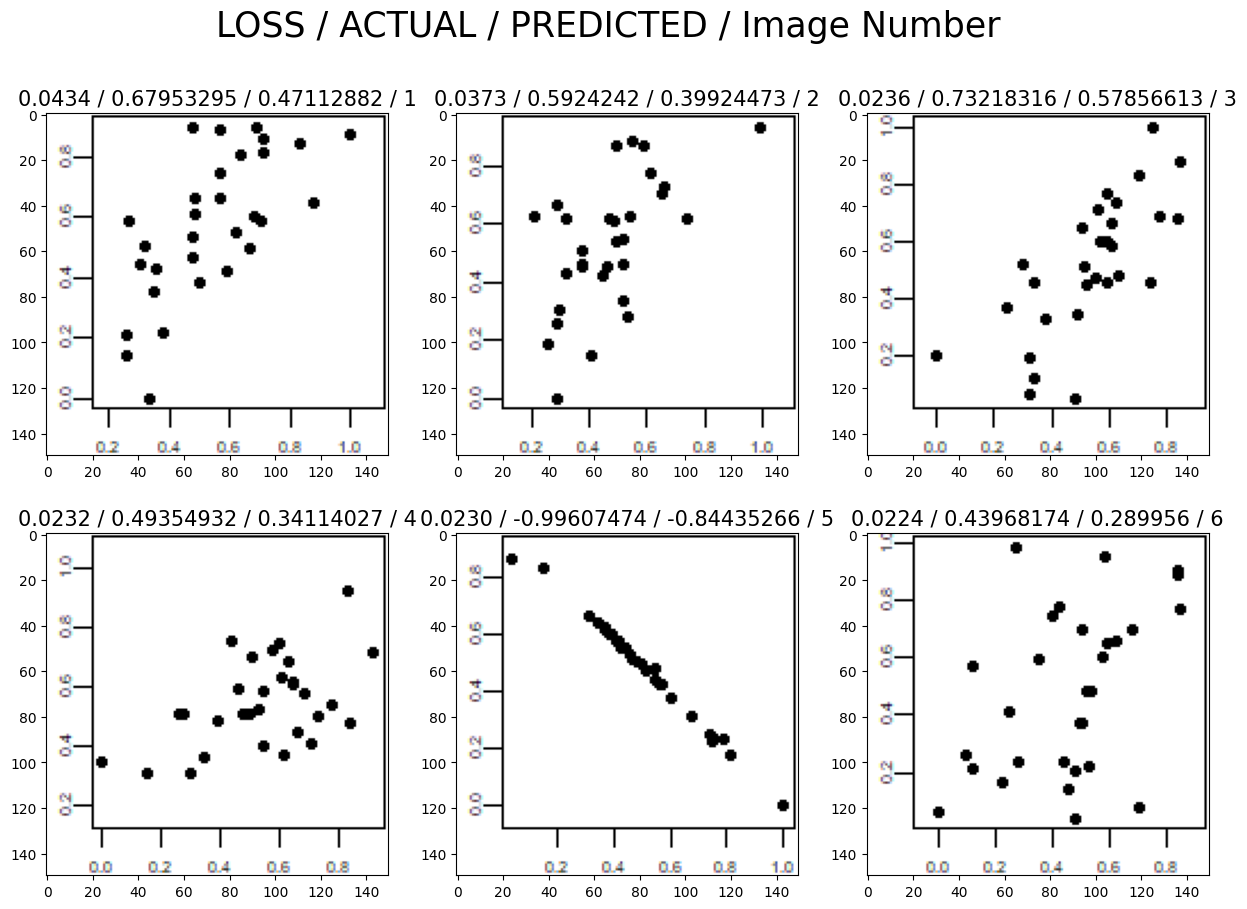

In [185]:
print(len(all_loss))
df = pd.read_csv('predictions_results.csv')

df_sorted = df.sort_values(by='loss', ascending=False)
top_6 = df_sorted.head(6)
print(top_6)

top_6_imageid = df_sorted['image_id'].tolist()
top_6_loss = df_sorted['loss'].tolist()
top_6_actual = df_sorted['actual'].tolist()
top_6_predicted = df_sorted['predicted'].tolist()

plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.subplot
    plt.suptitle("LOSS / ACTUAL / PREDICTED / Image Number", fontsize = 25)
    plt.title(f'{top_6_loss[i]:.4f} / {top_6_actual[i]} / {top_6_predicted[i]} / {i+1}', fontsize=15)
    img = img[i]
    img = plt.imread(f'input/images/{top_6_imageid[i]}.png')
    plt.imshow(img)
    plt.savefig('checkdata.png')

In [160]:
#visualize in scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_predictions, alpha=0.5)
plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.tight_layout()
plt.savefig('predictions_vs_actual.png')
plt.close()



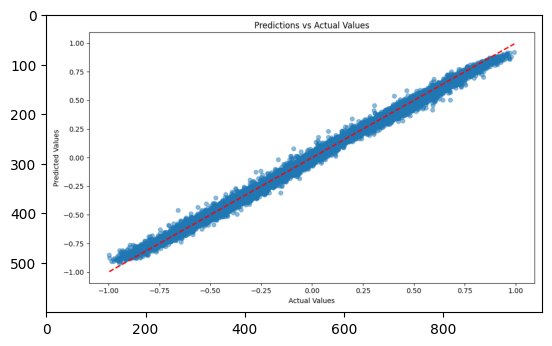

In [161]:
#show scatter plot
img = mpimg.imread('predictions_vs_actual.png')
plt.imshow(img)

In [103]:
print('saving model')
os.makedirs('saved_models', exist_ok=True)

torch.save(model, 'saved_models/cnn_model.pth')
print('Model saved successfully!')

saving model
Model saved successfully!
